In [183]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb
from desi_lowz_funcs import find_objects_nearby, print_radecs
from construct_dwarf_galaxy_catalogs import process_sga_matches


import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)

In [187]:
0

0

In [186]:
elg_temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")



In [190]:
elg_temp[elg_temp["TARGETID"] == 39627837166065738]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-240p000-250p005/2456p020/ELG_tgid_39627837166065738

In [ ]:
39627659063333387, 39627802919570075

In [4]:
from isolate_galaxy_mask import get_isolate_galaxy_mask, make_custom_cmap
%load_ext autoreload
%autoreload 2
    
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")



In [5]:
from sga_nsa_comp_funcs import collect_sga_mags, make_compare_plot, plot_sga
import cmasher as cmr

In [6]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")

# sga_cat = sga_cat[sga_cat["SHRED_MASKBIT"] == 0]


In [7]:
len(sga_cat)

6361


## Make the isolate visual with like 3 examples

In [143]:
tgids_vis = [39633086522066102, 39628230541445186, 39627737203215046, 39627612917597701]

In [78]:
##show grz image, 
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")
tot_cat = vstack([bgsb_cat, sga_cat])


In [82]:
bgsb_cat[bgsb_cat["TARGETID"]==39633019799078453]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/north/sweep-160p035-170p040/1632p370/BGS_BRIGHT_tgid_39633019799078453

In [140]:
from desi_lowz_funcs import sdss_gray

In [141]:
sga_cat[sga_cat["TARGETID"] == 39633086522066102]

<Table length=1>
     TARGETID     SURVEY ... LOGM_SAGA_COG_ISOLATE LOGM_SAGA_COG_NO_ISOLATE
                         ...                                               
      int64       bytes7 ...        float64                float64         
----------------- ------ ... --------------------- ------------------------
39633086522066102   main ...     9.187714246957286        9.187714246957286

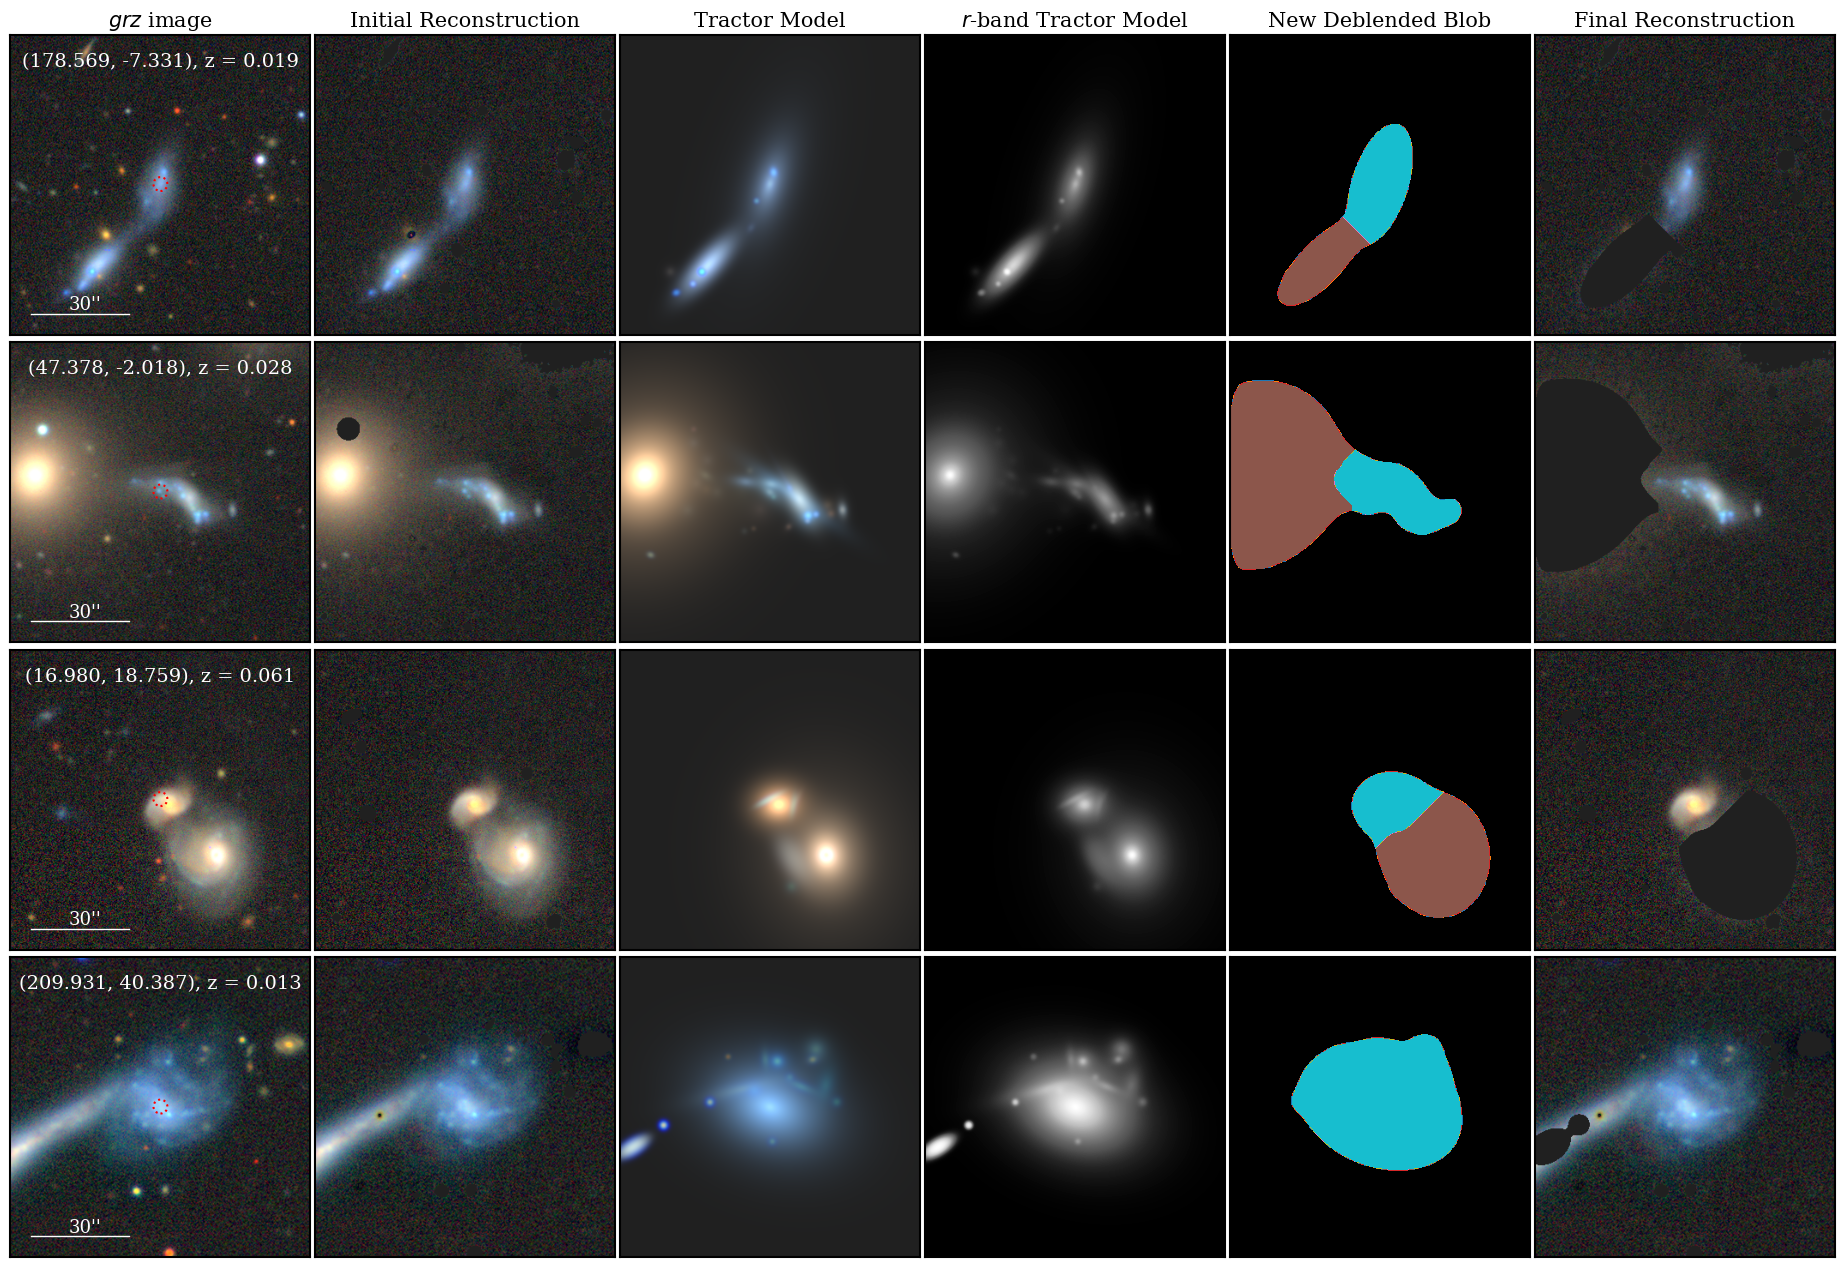

In [144]:
ax = make_subplots(ncol = 6, nrow = 4,col_spacing = 0.05,row_spacing = 0.075)

fs=15
ax[18].set_title(r"$grz$ image",fontsize = fs)
ax[19].set_title(r"Initial Reconstruction",fontsize = fs)
ax[20].set_title(r"Tractor Model",fontsize = fs)
ax[21].set_title(r"$r$-band Tractor Model",fontsize = fs)
ax[22].set_title(r"New Deblended Blob",fontsize = fs)
ax[23].set_title(r"Final Reconstruction",fontsize = fs)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

for k in range(4):

    ###

    cat = tot_cat[tot_cat["TARGETID"] == tgids_vis[k]]

    img_path = cat["IMAGE_PATH"][0]
    file_path = cat["FILE_PATH"][0]


    ra,dec, zred = cat["RA"][0], cat["DEC"][0], cat["Z"][0]
    cutout_size = 350
    
    #panel 0
    data_arr = fits.open(img_path)[0].data
    grz_img = process_img(data_arr, cutout_size = cutout_size, org_size = data_arr.shape[1])
    
    #panel 1
    ini_parent_recon = np.load(file_path + "/final_reconstruct_galaxy_no_cog_mask.npy")
    ini_parent_img = process_img(ini_parent_recon, cutout_size = cutout_size, org_size = data_arr.shape[1])
    
    #panel 2: tractor model
    trac_model = np.load(f"{file_path}/parent_galaxy_tractor_no_isolate_model.npy")
    trac_parent_img = process_img(trac_model, cutout_size=cutout_size, org_size = data_arr.shape[1])
    
    #panel 3: just r-band grey scale 
    trac_r_img = sdss_gray(trac_model[1], band="r")
    
    #panel 4: deblended segment 
    deblend_image = np.load(file_path + "/deblend_segments_isolate.npy")
    
    #panel 5: final reconstruction with the isolate mask applied?
    isolate_parent_mask = np.load(file_path + "/final_mask_cog_with_isolate.npy")
    iso_galaxy = np.copy(ini_parent_recon)
    iso_galaxy[:,isolate_parent_mask] = 0
    
    iso_img = process_img(iso_galaxy, cutout_size=cutout_size, org_size = data_arr.shape[1])



    ###

    ax[0+6*k].text(0.5,0.9125,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",color = "white",fontsize = 14, 
               transform=ax[0+6*k].transAxes,va="center",ha="center")
    
    ax[0+6*k].imshow(grz_img, origin="lower",rasterized=True)
    ax[1+6*k].imshow(ini_parent_img, origin="lower",rasterized=True)
    ax[2+6*k].imshow(trac_parent_img, origin="lower",rasterized=True)
    ax[3+6*k].imshow(trac_r_img, origin="lower",cmap="Greys_r",rasterized=True)
    
    ax[4+6*k].imshow(deblend_image, origin="lower",cmap = cmap_cstm,interpolation=None,rasterized=True)
    
    ax[5+6*k].imshow(iso_img, origin="lower",rasterized=True)
        
    # Define bar length in fraction of axes width (e.g., 0.3 = 30% of width)
    x_start_frac = 0.07  # 7% from left
    y_start_frac = 0.07  # 7% from bottom
    
    cutout_size = np.shape(grz_img)[1] * 0.262
    
    bar_frac = 30/cutout_size
    
    # Draw the scale bar in axes coordinates
    ax[0+6*k].plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],
            color='white', lw=1, transform=ax[0+6*k].transAxes)

    ax[0+6*k].text( x_start_frac + 0.55*bar_frac, y_start_frac + 0.03 ,"30''",color = "white",
                   transform=ax[0+6*k].transAxes,fontsize = 13,ha="center",va="center")
    
    ##draw a circle showing the DESI source!
    ax[0+6*k].scatter(cutout_size/2/0.262 , cutout_size/2/0.262 , facecolor='none',edgecolor='red',lw=1.5,s=100,linestyle='dotted')
    

plt.savefig("plots/isolating_galaxy_mask_construction.pdf",bbox_inches="tight")
        
plt.show()

#in the 2nd row, the tractor model itself fails a bit: https://www.legacysurvey.org/viewer?ra=209.9454&dec=40.3845&layer=ls-dr9-resid&zoom=14



## Read in the VI'ed catalogs

In [8]:
def process_vi_catalog(file_path):
    cat = Table.read(file_path)
    mask = (cat["IS_SHRED_VI"].data != b'nan') | (cat["IS_SHRED_VI"].data != b'ambi')
    cat = cat[mask]
    print(len(cat))
    over_deblend = np.zeros(len(cat))
    over_deblend[ cat["IS_SHRED_VI"] == b"over_deblend" ] = 1

    cat["OVER_DEBLEND"] = over_deblend
        
    return cat
    
bgsb_cat = process_vi_catalog("/pscratch/sd/v/virajvm/trash/nsa_bias_paper/deblend_num_VI/bgsb_more_blobs_labelled.fits")
# bgsf_cat = process_vi_catalog("/pscratch/sd/v/virajvm/trash/nsa_bias_paper/deblend_num_VI/bgsf_more_blobs_labelled.fits")
# lowz_cat = process_vi_catalog("/pscratch/sd/v/virajvm/trash/nsa_bias_paper/deblend_num_VI/lowz_more_blobs_labelled.fits")
sga_cat = process_vi_catalog("/pscratch/sd/v/virajvm/trash/nsa_bias_paper/deblend_num_VI/sga_more_blobs_labelled.fits")



995
311


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d


# all_vi_cat = vstack([bgsb_cat, bgsf_cat, lowz_cat, sga_cat])
all_vi_cat = vstack([bgsb_cat, sga_cat])


# 

In [10]:
len(all_vi_cat)

1306

In [23]:
## now we need to cross-match this with the other APER_R2 we have
sga_cat_new = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")
bgsb_cat_new = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")

all_cat_new = vstack([sga_cat_new, bgsb_cat_new])

#39627634514073574 -> THIS OBJECT STILL HAS THE WEIRD SOURCES REMAINING ... 
#_39633521446225446 -> CONFIRM IF THIS OBJECT IS DEBLENDED, IT IS NOT BEING OVER DEBLENDED -> it is being deblended!!

just an interlude of checking this source:

In [166]:
fold = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-030m010-040m005/0338m062/SGA_tgid_39627634514073574"

source_file = fold + "/source_cat_f_more.fits"
parent_source_file = fold + "/parent_galaxy_sources.fits"


In [167]:
source_cat = Table.read(source_file)
parent_cat = Table.read(parent_source_file)


In [157]:
source_cat[source_cat["ref_cat"] =="G2"]

<Table length=4>
BRICKID OBJID  type          ra        ...  mag_z_err     g-r_err     r-z_err   
 int32  int32 bytes3      float64      ...   float32      float32     float32   
------- ----- ------ ----------------- ... ------------ ----------- ------------
 294554  5933    PSF 33.86927859274887 ... 0.0014978192 0.009979676 0.0033567436
 294554  8328    DUP 33.87564151803738 ...           --          --           --
 293122  7069    PSF   33.882524976486 ...  0.003494903 0.007383586  0.004440255
 293122  9018    DUP 33.87564151803738 ...           --          --           --

In [158]:
## get all the sources close to this last one!
ra_bstar, dec_bstar = 33.87564151803738,	-6.3745399038590875

In [173]:
find_objects_nearby(source_cat, ra_bstar, dec_bstar, ra="ra",dec="dec", deg_rad=1.5/3600)

<Table length=10>
BRICKID OBJID  type  ...   mag_z_err     g-r_err     r-z_err   
 int32  int32 bytes3 ...    float32      float32     float32   
------- ----- ------ ... ------------- ----------- ------------
 294554  6137    SER ...  0.0048306277 0.068869136  0.006199003
 294554  6158    SER ...  0.0026532814 0.027091209 0.0038597167
 294554  6159    SER ... 0.00080008013 0.012005231 0.0011089265
 294554  8328    DUP ...            --          --           --
 293122  6817    SER ...  0.0048306193  0.06875336 0.0061984984
 293122  6833    SER ...  0.0026528297 0.026399722 0.0038655999
 293122  6834    PSF ...  0.0013094061 0.011063067 0.0017330118
 293122  6836    SER ...  0.0056249644   6.6000385    0.0078568
 293122  6839    REX ...  0.0036948945  0.09624766  0.008457362
 293122  9018    DUP ...            --          --           --

In [174]:
near_cat = find_objects_nearby(parent_cat, ra_bstar, dec_bstar, ra="ra",dec="dec", deg_rad=1.5/3600)

In [178]:
near_cat

<Table length=5>
BRICKID OBJID  type  ...    separations     marker source_objid_new
 int32  int32 bytes3 ...      float64       bytes1      int64      
------- ----- ------ ... ------------------ ------ ----------------
 294554  6137    SER ... 14.665129325562908      v               13
 294554  6158    SER ... 13.083307359014416      D               16
 294554  6159    SER ... 14.001800411396998      _               17
 293122  6836    SER ...  15.48177927504029      <               18
 293122  6839    REX ... 14.329607329048402      >               19

In [181]:
(near_cat["ra"].data - ra_bstar)*3600

array([-1.45264869,  0.07369636,  0.21671656,  0.50565103,  0.81963973])

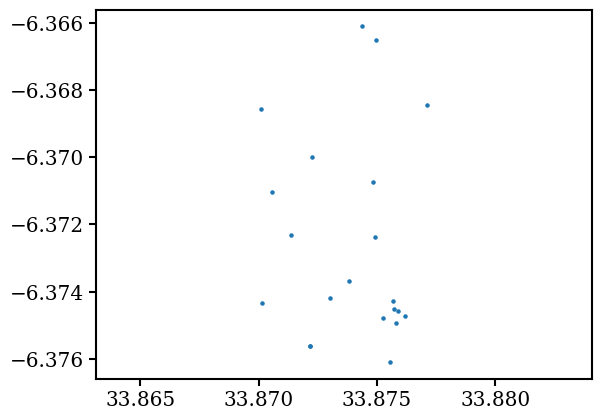

In [171]:
plt.scatter( parent_cat["ra"].data, parent_cat["dec"].data, s=5 )
plt.show()

In [150]:
## we will sub-select the VI catalog to objects that have NUM_DEBLEND > 1 in the updated pipeline code:
sga_cat_new[sga_cat_new["TARGETID"] == 39627634514073574]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes116' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-030m010-040m005/0338m062/SGA_tgid_39627634514073574

In [17]:
all_cat_new_num2 = all_cat_new[all_cat_new["DEBLEND_SMOOTH_NUM_BLOB"].data  > 1]

In [25]:
len(all_cat_new_num2)

1306

In [35]:
idx, d2d, _= match_c_to_catalog(c_cat=all_vi_cat, catalog_cat =  all_cat_new_num2)

In [39]:
all_vi_cat_f = all_vi_cat[d2d.arcsec < 1]
all_cat_new_num2_f = all_cat_new_num2[idx][d2d.arcsec < 1]

In [49]:
np.max(np.abs(all_vi_cat_f["TARGETID"].data - all_cat_new_num2_f["TARGETID"].data))

0

In [50]:
all_vi_cat_f["APER_R2_MU_R_ELLIPSE_TRACTOR"] = all_cat_new_num2_f["APER_R2_MU_R_ELLIPSE_TRACTOR"].data
all_vi_cat_f["APER_R2_MU_R_ISLAND_TRACTOR"] = all_cat_new_num2_f["APER_R2_MU_R_ISLAND_TRACTOR"].data


In [53]:
tgids_remove = np.array([39627717578069662, 39628442836142468 , 39632936303067573, 39627860863881071, 39627717540316542, 39627717540316453	])
#these were ambigious or VI updated, in second round!
#the last two are close to a bright star and thus often have iffy tractor models and so not reliable to look at

In [54]:
print(len(all_vi_cat_f))

all_vi_cat_ff = all_vi_cat_f[~np.isin(all_vi_cat_f["TARGETID"].data, tgids_remove)]

print(len(all_vi_cat_ff))

1282
1276


In [55]:
# 39628510922280854



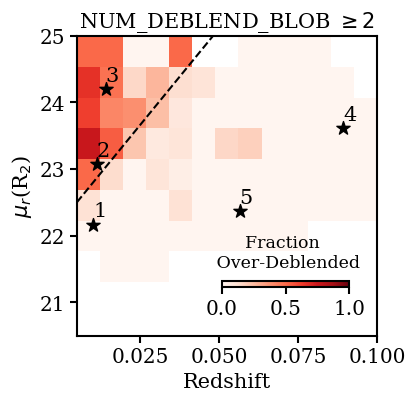

In [123]:

x = all_vi_cat_ff["Z"].data

col_name = "APER_R2_MU_R_ISLAND_TRACTOR"

y = all_vi_cat_ff[col_name].data
z = all_vi_cat_ff["OVER_DEBLEND"].data

nbins = 13

# Fraction in each bin = mean of z (since it's 0/1)
stat, xedges, yedges, binnumber = binned_statistic_2d(
    x, y, z, statistic="mean", bins=[nbins, nbins], range=[[0.005, 0.1], [19,25]]  # adjust bin numbers as needed
)

fig, ax = make_subplots(1,1,return_fig=True)

im = ax[0].imshow(
    stat.T, origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="auto", cmap="Reds", vmin=0, vmax=1, rasterized=True
)

 # Create a colorbar
cbar = plt.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.05)
cbar.set_ticks([0,0.5,1])
cbar.set_label("Fraction \n Over-Deblended",fontsize = 12.5,labelpad=-60)
cbar.ax.set_position([
    0.15,   # Left position
    0.175,  # Top position
    ax[0].get_position().width * 0.075,  # Width (40% of plot width)
    0.1  # Height (thin bar)
])
# # cbar.ax.tick_params(color="white", labelcolor="white", size=8)


ax[0].set_title(r"NUM_DEBLEND_BLOB $\geq 2$",fontsize = 15)

ax[0].set_xlabel("Redshift",fontsize = 15)
ax[0].set_ylabel("$\mu_r$(R$_2$)",fontsize = 15)
ax[0].set_xlim([0.005,0.1])
ax[0].set_ylim([20.5,25])

####

##make some scatter plots to show examples ... 

tgid_lowz_bright_mu = 39628510922280854 #39633489556931574 
tgid_lowz_bright_mu_2 = 39632995040103646
tgid_lowz_low_mu = 39627833768675783
tgid_hiz_low_mu = 39627538984599948
tgid_hiz_bright_mu = 39627490989180088

all_tgids = [ tgid_lowz_bright_mu_2, tgid_lowz_bright_mu, tgid_lowz_low_mu, tgid_hiz_low_mu, tgid_hiz_bright_mu  ]

# ax[0].scatter(0.0113, 23.07, color = "green")

for i in range(5):
    cat_plot_i = all_vi_cat_ff[all_vi_cat_ff["TARGETID"] == all_tgids[i]]
    
    ax[0].scatter( cat_plot_i["Z"].data,cat_plot_i[col_name].data,color = "k",marker= "*",s=100   )

    # label point with 1,2,3,4
    ax[0].text(cat_plot_i["Z"].data + 0.002,cat_plot_i[col_name].data + 0.2, 
               str(i+1), color="k", fontsize=15,ha="center", va="center", zorder=4)

##a simple linear boundary ... 

def num_deblend_blob_boundary(zred):
    '''
    Function that defines the linear boundary in zred vs. r2_mur space for considering objects that are likely over-deblended
    '''

    # ax[0].plot([0.005,0.1],[22.5,28], color = "k",ls = "--")
    slope = (28 - 22.5) / (0.1 - 0.005)
    y_intp = 28 - slope*0.1

    bound_value = slope * zred + y_intp

    return bound_value


def likely_over_deblended(zred, r2_mur):
    """
    Returns boolean array (or scalar if inputs are scalars) indicating
    whether the source is in the over-deblended regime.

    For sources that satisfy this mask, we use the 
    """
    
    bound_value = num_deblend_blob_boundary(zred)
    
    # core condition
    likely = r2_mur > bound_value
    
    # apply the zred < 0.005 override
    likely = np.where(zred < 0.005, True, likely)
    
    return likely


# ax[0].plot([0.005,0.1],[22.5,28], color = "k",ls = "--")
zgrid = np.linspace(0.005, 0.1,10)

ax[0].plot(zgrid, num_deblend_blob_boundary(zgrid),ls = "--",color = "k")
    

##how to add a colorbar
plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/num_deblend_blob.pdf",bbox_inches="tight")
plt.show()


In [145]:
slope = (28 - 22.5) / (0.1 - 0.005)
y_intp = 28 - slope*0.1
print(slope, y_intp)

57.89473684210526 22.210526315789473


In [111]:
all_cat_new_num2_f[all_cat_new_num2_f["TARGETID"].data == 39628510922280854]["Z","APER_R2_MU_R_ISLAND_TRACTOR","APER_R2_MU_R_ELLIPSE_TRACTOR","FILE_PATH"]



<Table length=1>
         Z          ...
      float64       ...
------------------- ...
0.01133915282392685 ...

57.89473684210526 22.210526315789473


In [75]:
temp = all_cat_new_num2_f[(all_cat_new_num2_f["Z"] < 0.012) & (all_cat_new_num2_f["Z"] > 0.01)]

In [78]:
from desi_lowz_funcs import get_scrollable_pdfs

all_sga_outlier_files = []

for i in range(len(temp)):
    file_path = temp["FILE_PATH"].data[i]
    
    if isinstance(file_path, bytes):
        file_path = file_path.decode()     
    else:
        pass  

    file_i = os.path.join(file_path, "cog_summary.png")
        #we use the isolate one    
    all_sga_outlier_files.append(file_i)

get_scrollable_pdfs(all_sga_outlier_files, "/pscratch/sd/v/virajvm/trash/sga_n2_vi.pdf")

    

Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/sga_n2_vi.pdf


In [225]:
over_deblend_classify = likely_over_deblended(all_vi_cat_f["Z"].data, all_vi_cat_f["APER_MU_R_ISLAND"].data)

In [104]:
# all_vi_cat_f[(all_vi_cat_f["Z"] < 0.05) & (all_vi_cat_f["OVER_DEBLEND"] == 1) & (all_vi_cat_f["APER_MU_R_ISLAND"] < 25) & (over_deblend_classify == False) ]["FILE_PATH","Z","APER_MU_R_ISLAND"]

# # all_vi_cat_f[(all_vi_cat_f["Z"] < 0.1) & (all_vi_cat_f["OVER_DEBLEND"] == 1) & (all_vi_cat_f["APER_MU_R_ISLAND"] < 25) & (over_deblend_classify == False) ]["FILE_PATH","Z","APER_MU_R_ISLAND"]


# # 39627509351849627 -> this is one that definitely should be isolated, but has low surface brightness??


In [261]:
## let us vi here all the objects that have been classified as 

temp_plot = all_vi_cat_f[(all_vi_cat_f["Z"] < 0.05) & (all_vi_cat_f["OVER_DEBLEND"] == 1) & (all_vi_cat_f["APER_MU_R_ISLAND"] < 25) & (over_deblend_classify == True) ]

print(len(temp_plot))


218


In [255]:
# 39627835534480059 -> potentially under-estimate weird photometry? also 39628052866536846


In [122]:
# 39627717578069662 -> this should be over_deblend = 0
#39627909735912674 -> hopefully this is flagged as a mistake?
# this is just unfortunaltey being too shredded: 39628001188515522
# 39628442836142468 -> this is ambiguous 
# 39632936303067573 -> this is good, this is also an example where Tractor has really weird models ... 
#could potentially find such objects where the source is very bright? And colors are weird?? Like r is weirdly faint??
# so could be something like g-r very negative, blue, and r-z very +ve, red?



### Get some statistics on how many galaxies have more than one component!

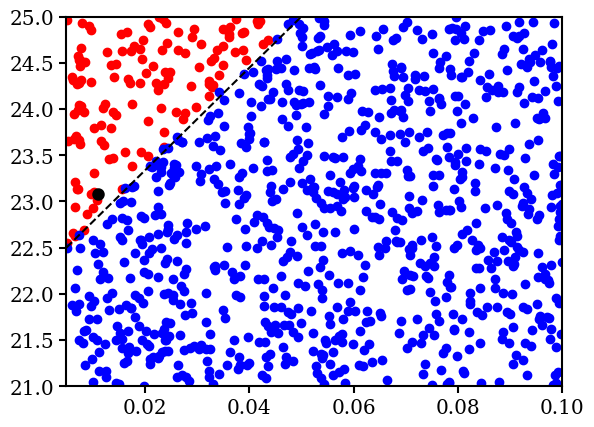

In [124]:
zred_rnd = np.random.uniform(low=0.005, high = 0.1,size = 1000)
r2_rnd = np.random.uniform(low=21, high = 25,size = 1000)

over_mask = likely_over_deblended(zred_rnd, r2_rnd )

plt.scatter( zred_rnd[over_mask], r2_rnd[over_mask], color = "r" )
plt.scatter( zred_rnd[~over_mask], r2_rnd[~over_mask], color = "b" )

plt.plot([0.005,0.05],[22.5,25], color = "k",ls = "--")

plt.scatter( [0.011],[23.08], color = "k",lw=3 )

plt.xlim([0.005,0.1])
plt.ylim([21,25])
plt.show()

In [125]:
len(all_vi_cat_ff)

1276

In [127]:
# col_name = 
over_mask_linear = likely_over_deblended(all_vi_cat_ff["Z"].data, all_vi_cat_ff["APER_R2_MU_R_ISLAND_TRACTOR"].data)

In [130]:
#of all the sources that are over deblended, I want to see what fraction of them this linear model correctly finds!!
over_deblend_vi = all_vi_cat_ff["OVER_DEBLEND"].data
np.sum(over_deblend_vi)/len(all_vi_cat_ff)
#so around 18% of all sources with NUM_DEBLEND >= 2 are over deblended

0.19122257053291536

In [148]:
correct_identify = (over_deblend_vi == 1) & (over_mask_linear == True)
all_identify_needed = (over_deblend_vi == 1)

print("Completeness at identifying the over deblended sources = ", np.sum(correct_identify) / np.sum( all_identify_needed )  )

#taking completeness of our linear model and multiplying by fraction of sources where NUM_DEBLEND >= 2
print("What fraction of entire likely shredded catalog is likely over-deblended because of this? = ", 0.2 * 0.05)


incorrect_identify = (over_deblend_vi == 0) & (over_mask_linear == True)
all_not_deblended = (over_deblend_vi == 0)

print("Fraction of correct deblended objects considered to be over deblended = ", np.sum(incorrect_identify) / np.sum( all_not_deblended ))


#and thus an even smaller fraction of the entire dwarf catalog!


Completeness at identifying the over deblended sources =  0.8114754098360656
What fraction of entire likely shredded catalog is likely over-deblended because of this? =  0.010000000000000002
Fraction of correct deblended objects considered to be over deblended =  0.19573643410852712


In [134]:
def measure_deblend_stats(file = "iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits"):
    temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/" + file)
    print(len(temp[(temp["DEBLEND_SMOOTH_NUM_BLOB"] > 1)])/len(temp))

    temp_deblend = temp[ (temp["Z"] > 0.005) & (temp["DEBLEND_SMOOTH_NUM_BLOB"] > 1)]
    
    #what fraction would be over deblended based on our criterion
    over_deblend_mask = likely_over_deblended(temp_deblend["Z"].data,  temp_deblend["APER_R2_MU_R_ISLAND_TRACTOR"].data )
    
    print(f"Fraction of NUM_BLOB > 1 sources that are likely over-deblended = { np.sum(over_deblend_mask)/len(over_deblend_mask) }")

    return temp_deblend[over_deblend_mask]


In [135]:
bgsb_over_deblend = measure_deblend_stats()

0.04829194024169759
Fraction of NUM_BLOB > 1 sources that are likely over-deblended = 0.2522167487684729


In [136]:
sga_over_deblend = measure_deblend_stats("iron_SGA_sga_catalog_w_aper_mags.fits")

0.04574752397421789
Fraction of NUM_BLOB > 1 sources that are likely over-deblended = 0.49828178694158076


In [137]:
# elg_over_deblend = measure_deblend_stats("iron_ELG_shreds_catalog_w_aper_mags.fits")

In [138]:
# lowz_over_deblend = measure_deblend_stats("iron_LOWZ_shreds_catalog_w_aper_mags.fits")

In [139]:
# bgsb_over_deblend["FILE_PATH"]

Now, let us show individual examples to see how this works ... 

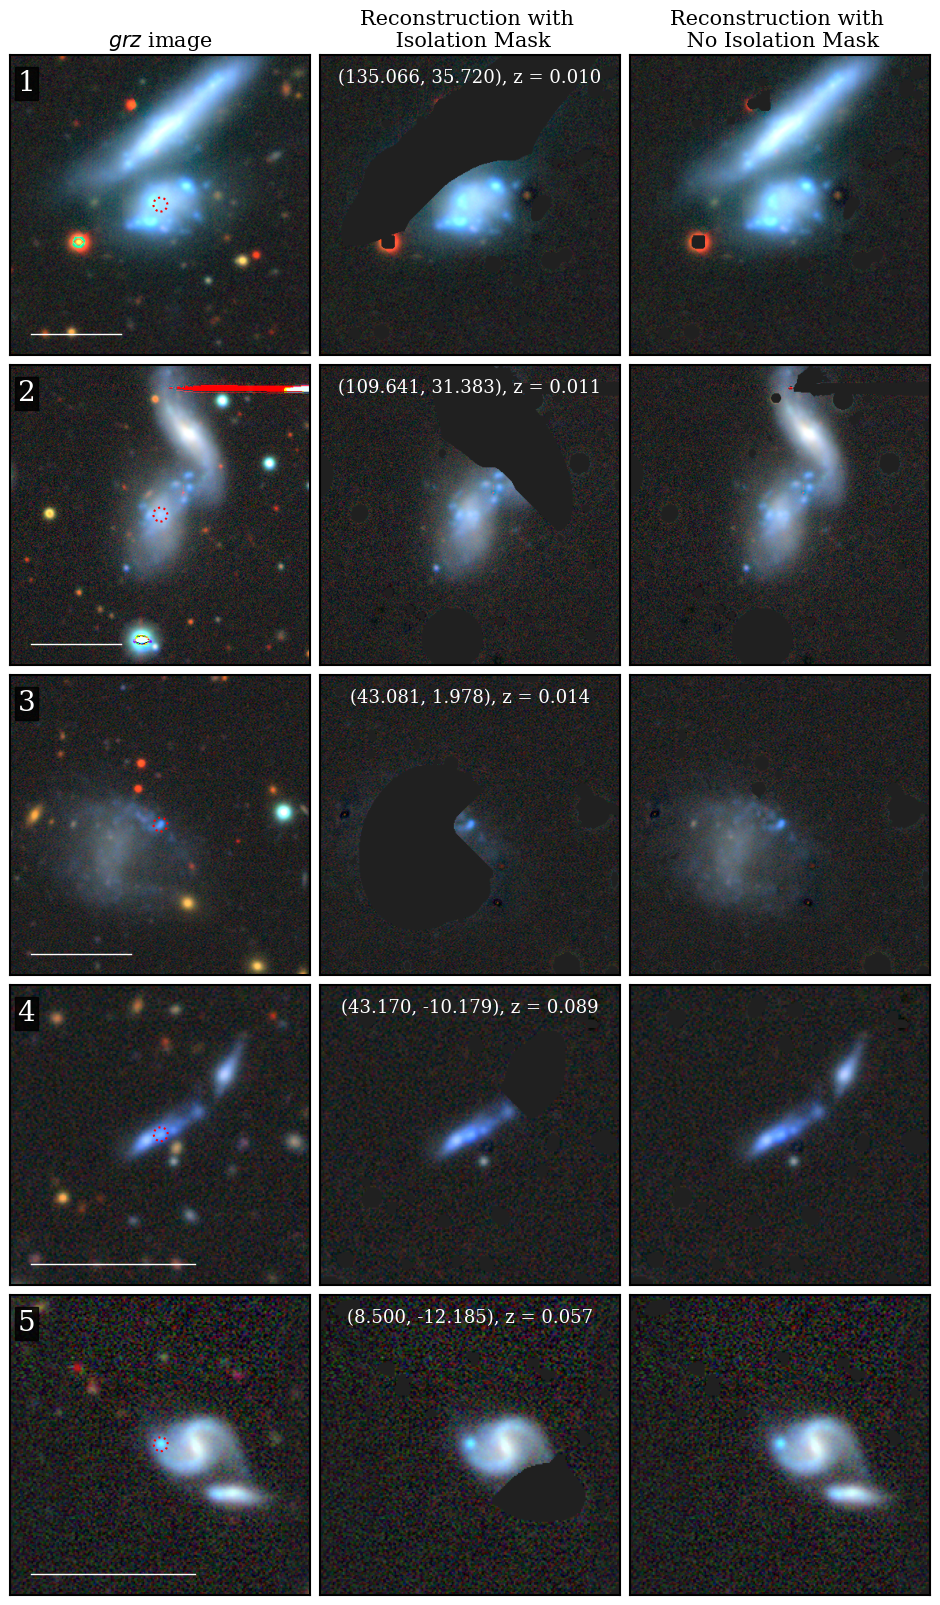

In [119]:
all_tgids = [ tgid_lowz_bright_mu_2, tgid_lowz_bright_mu, tgid_lowz_low_mu, tgid_hiz_low_mu, tgid_hiz_bright_mu  ][::-1]

# cut_sizes = [55,55,90,180,100]
cut_sizes = [55,55,90,100,100]


ax = make_subplots(ncol = 3, nrow = 5, col_spacing = 0.1,row_spacing = 0.1)

for k in range(5):
    
    cat_i = all_vi_cat[all_vi_cat["TARGETID"] == all_tgids[k]][0]

    file_path = cat_i["FILE_PATH"]
    img_path = cat_i["IMAGE_PATH"]
    
    
    ra,dec, zred = cat_i["RA"], cat_i["DEC"], cat_i["Z"]

    # print(zred, cut_sizes[k], all_tgids[k], file_path)
    
    data_arr = fits.open(img_path)[0].data
    
    ##download the smooth deblend mask 
    ini_parent_recon = np.load(file_path + "/final_reconstruct_galaxy_no_cog_mask.npy")
    
    no_isolate_parent_mask = np.load(file_path + "/final_mask_cog_no_isolate.npy")
    isolate_parent_mask = np.load(file_path + "/final_mask_cog_with_isolate.npy")
    
    ##plot the final reconstruction with the deblend mask applied!!
        
    # if cut_sizes[k] == -1:
    #     rgb_img = sdss_rgb(data_arr)
    #     rgb_ini_recon = sdss_rgb(ini_parent_recon)
    #     rgb_final_recon = sdss_rgb(final_parent_recon)
        
    # else:
    pix_size = int(cut_sizes[k]/0.262)
    rgb_img = process_img(data_arr, cutout_size=pix_size, org_size=data_arr.shape[1])

    rgb_ini_recon = process_img(ini_parent_recon, cutout_size=pix_size, org_size=data_arr.shape[1])

    isolate_recon = np.copy(ini_parent_recon)
    isolate_recon[:,isolate_parent_mask] = 0

    no_isolate_recon = np.copy(ini_parent_recon)
    no_isolate_recon[:,no_isolate_parent_mask] = 0
    
    rgb_isolate_recon = process_img(isolate_recon, cutout_size=pix_size, org_size=data_arr.shape[1])
    rgb_no_isolate_recon = process_img(no_isolate_recon, cutout_size=pix_size, org_size=data_arr.shape[1])
    
    
    #plotting now
    ax[0+3*k].imshow(rgb_img, origin="lower",rasterized=True)
    
    ax[1+3*k].imshow(rgb_isolate_recon, origin="lower",rasterized=True)
    
    ax[2+3*k].imshow(rgb_no_isolate_recon, origin="lower",rasterized=True)

    ##enter RA, DEC, redshift
    ax[1+3*k].text(0.5,0.925,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",size = 13,transform=ax[1+3*k].transAxes, 
            va='center',color = "white", ha="center")
    
    # ax.text(0.05,0.8,r"$r_{\rm mag,DR9} = %.1f$, FRACFLUX_R = %.2f, "%(rmag, data_table["FRACFLUX_R"][0]),size = fsize,transform=ax.transAxes, verticalalignment='top',color = "red",bbox=dict(facecolor='black', alpha=0.75, pad=5) )
    ax[0+3*k].text(0.025,0.95,r"%d"%(5-k),size = 20,transform=ax[0+3*k].transAxes, verticalalignment='top',color = "white",bbox=dict(facecolor='black', alpha=0.8, pad=2) )
    
    # Define bar length in fraction of axes width (e.g., 0.3 = 30% of width)
    x_start_frac = 0.07  # 7% from left
    y_start_frac = 0.07  # 7% from bottom
    
    cutout_size = np.shape(rgb_img)[1] * 0.262
    
    bar_frac = 30/cutout_size

    # print(bar_frac, cutout_size, cut_sizes[k])
    # print("--")
    
    # Draw the scale bar in axes coordinates
    ax[0+3*k].plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],
            color='white', lw=1, transform=ax[0+3*k].transAxes)
    
    ##draw a circle showing the DESI source!
    ax[0+3*k].scatter(cutout_size/2/0.262 , cutout_size/2/0.262 , facecolor='none',edgecolor='red',lw=1.5,s=100,linestyle='dotted')
    
    ##put the number at top to show what example we are talking about
     
ax[12].set_title(r"$grz$ image",fontsize = 15)
ax[13].set_title("Reconstruction with \n Isolation Mask",fontsize = 15)
ax[14].set_title("Reconstruction with \n No Isolation Mask",fontsize = 15)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/parent_isolation_mask.pdf",bbox_inches="tight")

plt.show()


## What fraction did we correctly label with this simple binary criterion??

In [439]:
print(len(all_label))
print(np.sum(over_deblend)/len(over_deblend))

# over_deblend = np.zeros(len(all_label))
# over_deblend[ all_label["IS_SHRED_VI"] == b"over_deblend" ] = 1

732
0.18032786885245902


In [446]:
no_apply_isolate_mask = (all_label["Z"].data < 0.035) & (all_label["APER_R2_MU_R_SMOOTH"].data > 21.5)

# ^^ the mask on which we do not apply isolate mask
# the goal is to check how many objects outside this range, that is, where we are going to apply this mask are over-deblended
#compute separate statistics for SGA and BGS Bright


In [469]:
np.sum((over_deblend == 1) & (~no_apply_isolate_mask))/np.sum(no_apply_isolate_mask)

0.029411764705882353

In [502]:
len(over_deblend)

732

In [503]:
np.sum(over_deblend == 1)/len(over_deblend)

0.18032786885245902

In [468]:
print(np.sum((over_deblend == 1) & (no_apply_isolate_mask))/np.sum(no_apply_isolate_mask))
print(np.sum((over_deblend == 0) & (no_apply_isolate_mask))/np.sum(no_apply_isolate_mask))

# /len(no_apply_isolate_mask)

0.3588235294117647
0.6411764705882353


In [471]:
from desi_lowz_funcs import make_cool_grz_panel

In [484]:
ambi_tgids = [39627865590862285, 39627830367096528, 39627929134565710, 39628006855017657, 39628059313177021, 39628357943431043, 39628403724257757,  39627794543543454]



In [485]:
for tgidi in ambi_tgids:
    temp = all_label[all_label["TARGETID"] == tgidi]
    print(temp["RA"][0], temp["DEC"][0])

140.1320837493903 3.308804199154349
200.43204171651664 1.7489648316244044
336.75996793813283 5.839987441123785
324.90435217320834 8.953947572203013
258.67912345047307 11.252122731785093
246.6537295558691 24.355634548765245
20.770719523427825 26.552529301364615
225.05348843927032 0.33975271681417496


In [2]:
tgid_examples = [39627737203215046, 39633086522066102, 39627612917597701, 39628230541445186, 39628010881548661, 39627999485624747]



In [15]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags_Sep10.fits")




In [25]:
file_path = sga_cat[sga_cat["TARGETID"] == 39633086522066102]["FILE_PATH"][0]
img_path = sga_cat[sga_cat["TARGETID"] == 39633086522066102]["IMAGE_PATH"][0]


In [78]:
data_arr = fits.open(img_path)[0].data

recon_parent = np.load( file_path + "/final_reconstruct_galaxy_no_cog_mask.npy")

parent_isolate_mask = np.load(file_path + "/final_mask_cog_with_isolate.npy")

try:
    parent_tractor_model = np.load(file_path + "/parent_galaxy_tractor_isolate_model.npy")
except:
    

FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-200p040-210p045/2100p405/SGA_tgid_39633086522066102/parent_galaxy_tractor_isolate_model.npy'

In [75]:
grz_img = process_img(data_arr, cutout_size = 350, org_size = data_arr.shape[1])

recon_img = process_img(recon_parent, cutout_size = 350, org_size = recon_parent.shape[1])

recon_parent[:,parent_isolate_mask.astype(bool)] = 0
recon_isolate_img = process_img(recon_parent, cutout_size = 350, org_size = recon_parent.shape[1])


In [76]:
deblend_seg_iso = np.load(file_path + "/deblend_segments_isolate.npy")



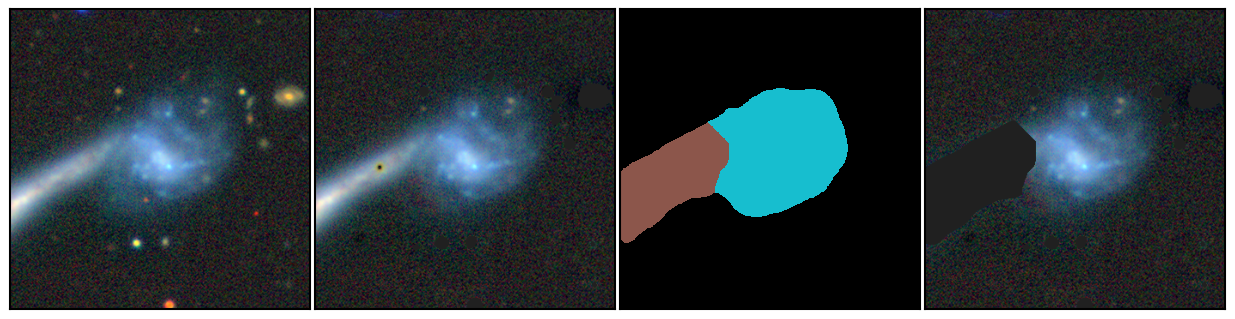

In [77]:
ax = make_subplots(ncol = 5, nrow = 1,col_spacing = 0.05)

ax[0].imshow(grz_img, origin="lower")

ax[1].imshow(recon_img, origin="lower")

ax[2].imshow(deblend_seg_iso,cmap = cmap_cstm,interpolation="none", origin="lower")

ax[3].imshow(recon_isolate_img, origin="lower")

ax[4].imshow()

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

plt.show()

In [79]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux.fits")